<div class="title">Practical Assignment: Supervised Learning</div>
<div class="subtitle">Machine Learning</div>
<div class="author">Carlos María Alaíz Gudín - Universidad Autónoma de Madrid</div>

---


<div style="font-size: large; font-weight: bold; margin-left: 6em;">
    <p>Names: <u>Elena Aguayo Jara, Yiran Du</u>
    <p>Team Number: <u>03</u>
</div>

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [8]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

In [9]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This cell imports the packages to be used (all of them quite standard except for `utils`, which is provided with the notebook.

In [10]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, balanced_accuracy_score

########################################
# Any other needed package can be imported here:
from sklearn.manifold import MDS
import pandas as pd
import seaborn as sns
from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
import matplotlib.image as mpimg
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import Lasso
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.model_selection import cross_val_score

########################################
import warnings
warnings.filterwarnings('ignore')
########################################

from utils import plot_dataset_clas

matplotlib.rc('figure', figsize=(15, 5))
seed = 123

# Preliminaries

## Introduction

This practical assignment is designed as a competition.

Specifically, a **multiclass classification** dataset will be used, so that each team will compete to improve their predictions over an unlabeled partition of the dataset.

It is important to remark that **the grades will not depend on the obtained team ranking**, but on the different approaches used to tackle the problem, on the design of the experiments and on the analysis of the results.

## Rubric

The following aspects will be taken into account when evaluating the assignment.


* Analyse the data.


* Preprocess the features automatically using *pipelines*.


* Adjust the hyper-parameters with a validation stage.


* Try different models to improve the performance, at least:
    * (Regularized) Logistic Regression.
    * SVC.
    * ANNs.


* Try interpretable models to check the important features (e.g. Lasso).


* Submit the prediction several times (the evolution of the performance will be also considered).


* Any other approach that may improve either the performance or interpretability of the model (e.g. feature selection, ensembles...).


* Analyse the results obtained after each experiment, and make decisions following the conclusions.

## Utilities

Some utilities are given next as a starting point, but the teams can defined any other tools that they may need.

### Team Number

The **number of the team** should be inserted here, so that the file of predictions has the appropriate name.

In [11]:
########################################
# The team number should be inserted here:
team_number = 3
########################################

### Evaluation of the Model

The following function evaluates a multiclass model (already fitted), computing and showing the accuracy and balanced accuracy over both the training and test partitions.

In [12]:
def evaluate_model(model, X_tr, y_tr, X_te, y_te, print_table=True):
    y_tr_p = model.predict(X_tr)
    y_te_p = model.predict(X_te)

    er_tr = [accuracy_score(y_tr, y_tr_p), balanced_accuracy_score(y_tr, y_tr_p)]
    er_te = [accuracy_score(y_te, y_te_p), balanced_accuracy_score(y_te, y_te_p)]

    ers = [er_tr, er_te]
    headers=["Acc", "Bal. Acc"]

    if print_table:
        print("{:>15}".format(""), end="")
        for h in headers:
            print("{:>15}".format(h), end="")
        print("")

        headersc = ["Train", "Test"]

        cnt = 0
        for er in ers:
            hc = headersc[cnt]
            cnt = cnt + 1
            print("{:<15}".format(hc), end="")

            for e in er:
                print("{:15.2f}".format(e), end="")
            print("")

    return ers

## Submission of the Predictions

The following function saves the predictions on the **challenge partition** to a file with syntax `Team_TT_YYYYMMDD-HHMMSS.pred`, where `TT` stands for the team number, and `YYYYMMDD-HHMMSS` is a timestamp to distinguish the different submissions of a team.

In [13]:
import time

def save_predictions(y_ch_p, n_preds=500):
    if (len(y_ch_p) != n_preds):
        print("Error saving the predictions, it should be a vector of %d lables" % n_preds)
    else:
        time_str = time.strftime("%Y%m%d-%H%M%S")
        np.savetxt("Team_{:02d}_{}.txt".format(team_number, time_str), y_ch_p, fmt="%d")

Once the prediction file has been generated, it can be uploaded.

# Dataset

A real dataset will be tackled in this practical assignment.
In particular, the [fetal health](https://www.kaggle.com/andrewmvd/fetal-health-classification) dataset of Kaggle, that aims to classify the fetal health in three classes:
1. Normal.
2. Suspect.
3. Pathological.

The input data are a set of $21$ variables extracted from the cardiotocographies (CTGs).

## Load of the Dataset

This cell loads the data, in particular three partitions:
1. A training partition, given by `X_tr` and `y_tr`, to train (and validate) the models.
2. A test partition, given by `X_te` and `y_te`, to estimate the performance of the model.
3. A challenge partition, given by `X_ch`. The real labels are unknown, and hence the predictions should be submitted to know the real performance of the model.

In [14]:
rootf = "./Data/fetal_health"

X_tr = np.loadtxt(rootf + "_tr.dat")
X_te = np.loadtxt(rootf + "_te.dat")
X_ch = np.loadtxt(rootf + "_ch.dat")

y_tr = np.loadtxt(rootf + "_tr.lab")
y_te = np.loadtxt(rootf + "_te.lab")

features = [line.rstrip('\n') for line in open("./Data/fetal_health.head")]
n_features = len(features)

## Initial Analysis

Plot of the data over the first two features.

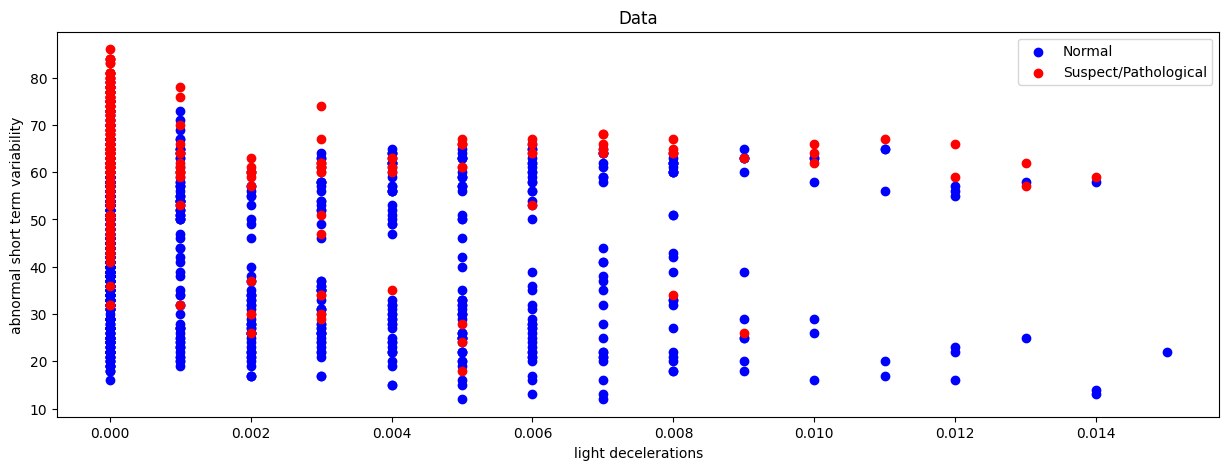

In [15]:
plot_dataset_clas(X_tr, y_tr)
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.legend(["Normal", "Suspect/Pathological"])
plt.axis("auto")
plt.show()

The plot above displays a dataset of two features, where the x-axis represents feature 1 ('light decelerations') and the y-axis represents feature 2(abnormal short term variability'). There are two classes in the plot, normal (blue dots) and suspect/pathological (red dots). The plot provides a visual representation of the distribution of the dataset in two dimensions.

It can be observed that there is some overlap between the two classes, which might make it challenging to classify instances solely based on these two features.

In [16]:
mds = MDS(n_components=2, random_state=42)
X_mds = mds.fit_transform(X_tr)

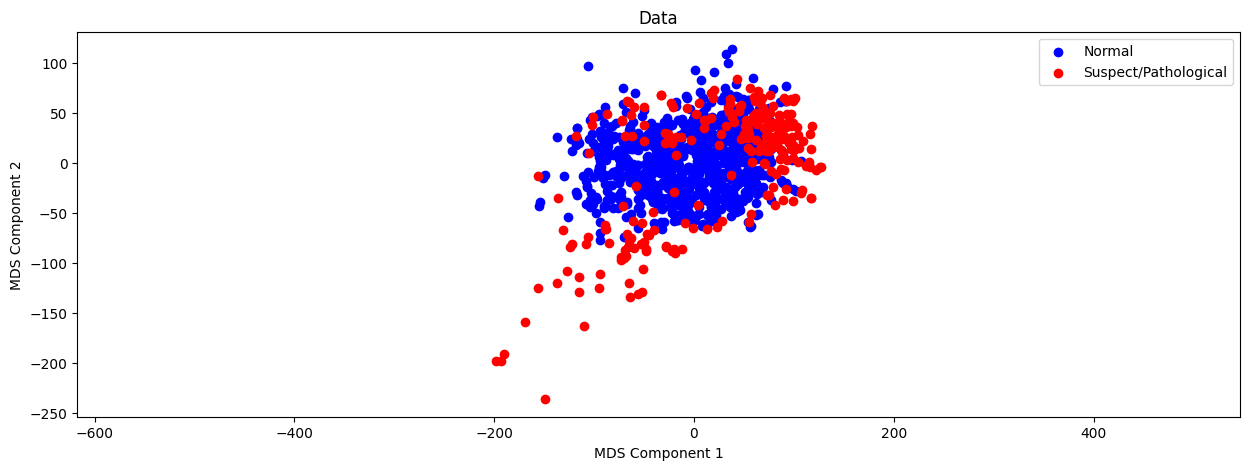

In [17]:
plot_dataset_clas(X_mds, y_tr)
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.legend(["Normal", "Suspect/Pathological"])
plt.show()

The scatter plot shows the results of running MDS on a dataset with 21 features, reducing the dimensionality to two dimensions. The plot displays the distribution of the data points in two dimensions, with each point representing an observation from the original dataset. The color of each point corresponds to its class label, with different colors used for
each class.

The MDS algorithm has grouped similar observations closely together in the lower-dimensional space. From the plot, we can see that there is some degree of separation between the different classes, although there are also some overlaps.

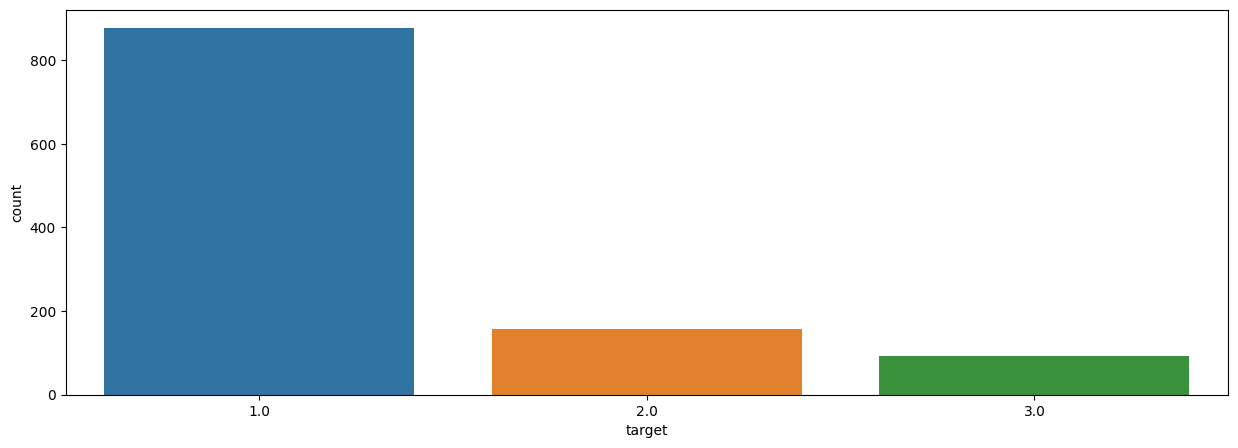

In [18]:
df = pd.DataFrame(X_tr, columns=['feature_'+str(i) for i in range(X_tr.shape[1])])
df['target'] = y_tr

sns.countplot(x='target', data=df)
plt.show()



The plot shows the distribution of the target variable in the original dataset. The target variable has multiple classes, each represented by a different color in the plot. We can see that there is a clear imbalance in the distribution of the target variable, with some classes having significantly fewer observations than others.

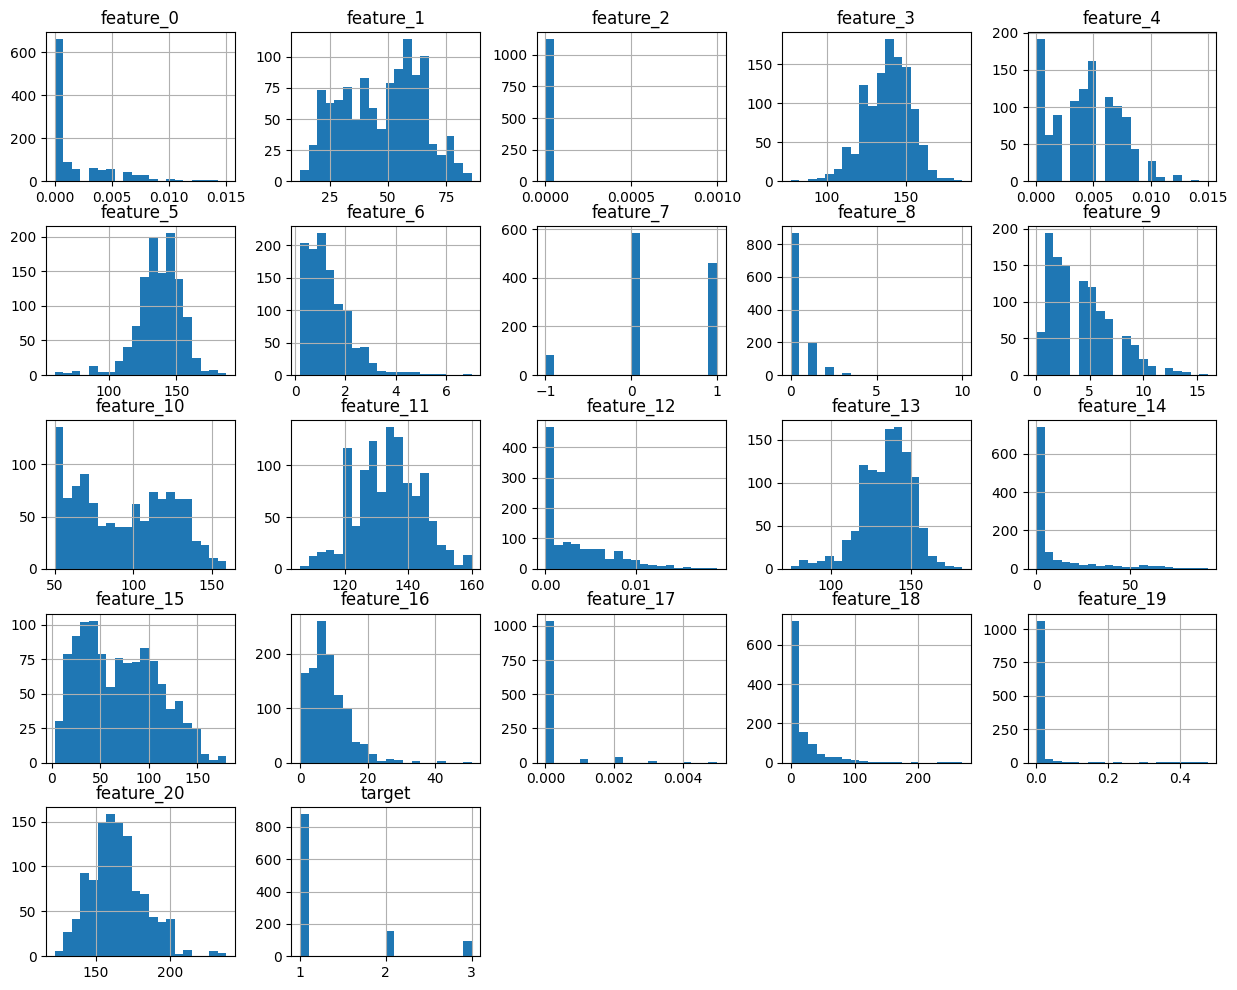

In [19]:
df.hist(bins=20, figsize=(15.1,12))
plt.show()

The plot above shows the distribution of the features in the original dataset, with each feature represented by a separate histogram. We can see that the features have different ranges and distributions, which suggests that some normalization or scaling might be necessary before using them in machine learning models.

## Balance of the dataset

In [20]:
for lab in np.unique(y_tr):
    n_sam = np.sum(y_tr == lab)
    print("Class {}: {:3d} samples ({:5.2f}%)".format(lab, n_sam, 100.0 * n_sam / len(y_tr)))

Class 1.0: 877 samples (77.89%)
Class 2.0: 156 samples (13.85%)
Class 3.0:  93 samples ( 8.26%)


In [21]:
print(f"{X_tr.shape=:}")
print(f"{y_tr.shape=:}")
print(f"{X_te.shape=:}")
print(f"{y_te.shape=:}")
print(Counter(y_tr))

X_tr.shape=(1126, 21)
y_tr.shape=(1126,)
X_te.shape=(500, 21)
y_te.shape=(500,)
Counter({1.0: 877, 2.0: 156, 3.0: 93})


## Preprocessing pipeline

In [22]:
preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

X_train_preprocessed = preprocessing_pipeline.fit_transform(X_tr)
X_test_preprocessed = preprocessing_pipeline.transform(X_te)

# **Experiments**

## Experiment 1: Logistic Regression

The key steps in our analysis included the setting up of the parameter grid, the creation of the GridSearchCV object, and the fitting of the GridSearchCV object.

For the parameter grid, we used two important hyperparameters - 'C' and 'penalty'. 'C' is essentially the inverse of regularization strength, where smaller values imply stronger regularization, used to deter overfitting. We chose to explore a range of 'C' values on a logarithmic scale ([0.001, 0.01, 0.1, 1, 10, 100]) to comprehensively cover potential optimal values. The 'penalty' hyperparameter defines the type of regularization applied. We selected 'l1' and 'l2' for consideration, representing L1 (Lasso) and L2 (Ridge) regularization respectively.

We then proceeded to set up the GridSearchCV object. For our logistic regression model, we used balanced class weights and the 'liblinear' solver. We fed the parameter grid from our initial step to the GridSearchCV object, thus prompting it to iterate over every combination of parameters in the grid. Furthermore, we decided on a 5-fold cross-validation, indicated by the cv parameter being set to 5.

In the next step, we fit the GridSearchCV object. Essentially, we instructed the GridSearchCV to train a model for each combination of parameters present in our parameter grid and evaluated each using 5-fold cross-validation. This grid search strategy allowed the model to discern the optimal parameters based on the training data.

In [23]:
logistic_regression_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

logistic_regression_grid = GridSearchCV(
    LogisticRegression(class_weight='balanced', solver='liblinear'),
    param_grid=logistic_regression_param_grid,
    cv=5
)

logistic_regression_grid.fit(X_train_preprocessed, y_tr)

print('Best hyperparameters:', logistic_regression_grid.best_params_)
print('Best score:', logistic_regression_grid.best_score_)

best_model = logistic_regression_grid.best_estimator_
y_pred = best_model.predict(X_test_preprocessed)

report = classification_report(y_te, y_pred)
print(report)

evaluate_model(best_model, X_train_preprocessed, y_tr, X_test_preprocessed, y_te, print_table=True)

Best hyperparameters: {'C': 1, 'penalty': 'l2'}
Best score: 0.8960983284169124
              precision    recall  f1-score   support

         1.0       0.96      0.93      0.94       389
         2.0       0.61      0.76      0.68        70
         3.0       0.82      0.78      0.80        41

    accuracy                           0.89       500
   macro avg       0.80      0.82      0.81       500
weighted avg       0.90      0.89      0.89       500

                           Acc       Bal. Acc
Train                     0.90           0.84
Test                      0.89           0.82


[[0.8987566607460036, 0.8427824510143266], [0.89, 0.8210268444954005]]

In [24]:
# LR
X_ch_preprocessed = preprocessing_pipeline.transform(X_ch)
best_model = logistic_regression_grid.best_estimator_
y_ch_p = best_model.predict(X_ch_preprocessed)
save_predictions(y_ch_p)

The best hyperparameters are found to be C=1 with penalty='l2', and the best crossvalidation score is 0.896.

The best model is then used to make predictions on the test set X_te, and the performance of the model is evaluated using classification metrics such as precision, recall, and f1-score.

The results show that the macro avg of recalling the model is 0.82, but we can also see that the model performs better on the majority class (class 1) than on the minority classes (classes 2 and 3). This can be explained by the class imbalance issue, and suggests that the model may need additional adjustments to improve its performance on the minority classes.

## Experiment 2: K-Neighbors Classifier (KNN)

In this case, we specifies the hyperparameters for the k-nearest neighbors (a predictive algorithm) that will be used in a grid search to find the best combination of hyperparameters for the model.

First, we have n_neighbors, a list of values [1, 5, 10, 25, 45, 50] representing the number of nearest neighbors to consider in the algorithm. Different values will be tested to determine which one produces the best performance.

Then, weights, a list of options that specifies how the nearest neighbors will be weighted. 'uniform' means all neighbors will have the same weight, while 'distance' assigns weights to neighbors based on the inverse of their distance. Both options will be tested to determine which one works better.

Also, we have metric, a list of options ['euclidean', 'manhattan'] indicating the distance metric to use for calculating distances between instances. 'euclidean' represents Euclidean distance, and 'manhattan' represents Manhattan distance. Both metrics will be tested to determine which one is more suitable for the dataset.

In [25]:
# Define hyperparameters for knn
kneighbors_param_grid = {
    'n_neighbors': [1,5,10,25,45,50],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
# 5-fold cross validation
knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=kneighbors_param_grid,
    cv=5
)

knn_grid.fit(X_train_preprocessed, y_tr)

print('Best hyperparameters:', knn_grid.best_params_)
print('Best score:', knn_grid.best_score_)

best_model = knn_grid.best_estimator_
y_pred = best_model.predict(X_test_preprocessed)

report = classification_report(y_te, y_pred)
print(report)

evaluate_model(best_model, X_train_preprocessed, y_tr, X_test_preprocessed, y_te, print_table=True)

Best hyperparameters: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Best score: 0.9005231071779743
              precision    recall  f1-score   support

         1.0       0.92      0.97      0.94       389
         2.0       0.72      0.63      0.67        70
         3.0       0.97      0.71      0.82        41

    accuracy                           0.90       500
   macro avg       0.87      0.77      0.81       500
weighted avg       0.90      0.90      0.89       500

                           Acc       Bal. Acc
Train                     1.00           1.00
Test                      0.90           0.77


[[1.0, 1.0], [0.898, 0.7674898262019711]]

In [26]:
# KNN
X_ch_preprocessed = preprocessing_pipeline.transform(X_ch)
best_model = knn_grid.best_estimator_
y_ch_p = best_model.predict(X_ch_preprocessed)
save_predictions(y_ch_p)

The results show that the macro avg of recalling the KNN model is 0.77, which is lower than the accuracy of the logistic regression model. Tthis might indicate that we need to test other models.

## Experiment 3: Naive Bayes Classifier

In this analysis, we use a generative model, the Naive Bayes classifier. First, we choose one of this distributions: GaussianNB and BernoulliNB. 

GaussianNB: this distribution assumes that the features follow a Gaussian (normal) distribution. It is suitable for continuous or real-valued features.

BernoulliNB: this distribution assumes that the features are binary or can be transformed into binary values. It is suitable for features that represent presence or absence of certain attributes. 

In [27]:
classifiers = {
    'GaussianNB': GaussianNB(),
    'BernoulliNB': BernoulliNB(),
}

# Assessment by cross-validation
results = {}
for name, clf in classifiers.items():
    scores = cross_val_score(clf, X_train_preprocessed, y_tr, cv=5)  # Ajusta X y y a tus datos
    results[name] = scores.mean()

# Determining the best classifier
best_classifier = max(results, key=results.get)

print("Resuls of the cross-validation:")
for name, score in results.items():
    print(f"{name}: {score}")

print("\nThe best classifier is:", best_classifier)

Resuls of the cross-validation:
GaussianNB: 0.7584660766961651
BernoulliNB: 0.808165191740413

The best classifier is: BernoulliNB


As we can see, the best classifier is Bernoulli. To prove it we make the Naive Bayes classifier with GaussianNB and Bernoulli BN distribution.

In [28]:
# Define hyperparameters for Naive Bayes
naive_bayes_param_grid = {}

# 5-fold cross validation with GaussianNB
nc_g_grid = GridSearchCV(
    GaussianNB(),
    param_grid=naive_bayes_param_grid,
    cv=5
)

nc_g_grid.fit(X_train_preprocessed, y_tr)

print('Best hyperparameters:', nc_g_grid.best_params_)
print('Best score:', nc_g_grid.best_score_)

best_model = nc_g_grid.best_estimator_
y_pred = best_model.predict(X_test_preprocessed)

report = classification_report(y_te, y_pred)
print(report)

evaluate_model(best_model, X_train_preprocessed, y_tr, X_test_preprocessed, y_te, print_table=True)


Best hyperparameters: {}
Best score: 0.7584660766961651
              precision    recall  f1-score   support

         1.0       1.00      0.69      0.82       389
         2.0       0.34      0.91      0.50        70
         3.0       0.60      0.63      0.62        41

    accuracy                           0.72       500
   macro avg       0.65      0.75      0.65       500
weighted avg       0.88      0.72      0.76       500

                           Acc       Bal. Acc
Train                     0.74           0.76
Test                      0.72           0.75


[[0.738898756660746, 0.7623661572791671], [0.72, 0.7475064864493669]]

In [29]:
# Naive Bayes Gaussian
X_ch_preprocessed = preprocessing_pipeline.transform(X_ch)
best_model = nc_g_grid.best_estimator_
y_ch_p = best_model.predict(X_ch_preprocessed)
save_predictions(y_ch_p)

In [30]:
# Define hyperparameters for Naive Bayes
naive_bayes_param_grid = {}

# 5-fold cross validation with BernoulliNB
nc_b_grid = GridSearchCV(
    BernoulliNB(),
    param_grid=naive_bayes_param_grid,
    cv=5
)

nc_b_grid.fit(X_train_preprocessed, y_tr)

print('Best hyperparameters:', nc_b_grid.best_params_)
print('Best score:', nc_b_grid.best_score_)

best_model = nc_b_grid.best_estimator_
y_pred = best_model.predict(X_test_preprocessed)

report = classification_report(y_te, y_pred)
print(report)

evaluate_model(best_model, X_train_preprocessed, y_tr, X_test_preprocessed, y_te, print_table=True)


Best hyperparameters: {}
Best score: 0.808165191740413
              precision    recall  f1-score   support

         1.0       0.95      0.83      0.88       389
         2.0       0.50      0.73      0.59        70
         3.0       0.51      0.71      0.59        41

    accuracy                           0.80       500
   macro avg       0.65      0.75      0.69       500
weighted avg       0.85      0.80      0.82       500

                           Acc       Bal. Acc
Train                     0.81           0.77
Test                      0.80           0.75


[[0.8126110124333925, 0.7738728823070605], [0.804, 0.7545506659620397]]

In [31]:
# Naive Bayes Bernoulli
X_ch_preprocessed = preprocessing_pipeline.transform(X_ch)
best_model = nc_b_grid.best_estimator_
y_ch_p = best_model.predict(X_ch_preprocessed)
save_predictions(y_ch_p)

The accuracy is better with the bernoulli classifier. As we can see, the macro avg (0.75) is even more lower than the KNN model. It may indicate that measure distances is not a good measure of this data.

## Experiment 4: Nearest Shrunken Centroids (NSC)

The Nearest Shrunken Centroids (NSC) algorithm performs feature selection by shrinking the centroids.

Therefore, in the case of NSC, the nsc_regularization dictionary includes the 'shrink_threshold' value, which specifies the threshold for shrinking the centroids. 

In [32]:
nsc_regularization = {
    'shrink_threshold': [None, 0.1, 0.5, 1.0, 2.0],
}

#  5-fold cross validation
nsc_grid = GridSearchCV(
    NearestCentroid(),
    param_grid=nsc_regularization,
    cv=5
)

nsc_grid.fit(X_train_preprocessed, y_tr)

print('Best hyperparameters:', nsc_grid.best_params_)
print('Best score:', nsc_grid.best_score_)

best_model = nsc_grid.best_estimator_
y_pred = best_model.predict(X_test_preprocessed)

report = classification_report(y_te, y_pred)
print(report)

evaluate_model(best_model, X_train_preprocessed, y_tr, X_test_preprocessed, y_te, print_table=True)


Best hyperparameters: {'shrink_threshold': None}
Best score: 0.775331366764995
              precision    recall  f1-score   support

         1.0       0.99      0.79      0.88       389
         2.0       0.41      0.84      0.55        70
         3.0       0.59      0.63      0.61        41

    accuracy                           0.79       500
   macro avg       0.66      0.76      0.68       500
weighted avg       0.87      0.79      0.81       500

                           Acc       Bal. Acc
Train                     0.77           0.76
Test                      0.79           0.76


[[0.7744227353463587, 0.756489479794736], [0.788, 0.7571159857760899]]

In [33]:
# NSC
X_ch_preprocessed = preprocessing_pipeline.transform(X_ch)
best_model = nsc_grid.best_estimator_
y_ch_p = best_model.predict(X_ch_preprocessed)
save_predictions(y_ch_p)

Again, the accuracy and the recall avg are lower than the logistic regression, so we have to try another model.

## Experiment 5: SVC

In this analysis, we set out to optimize the hyperparameters of a Support Vector Machine (SVM) model. The hyperparameters in consideration were: 'C', 'kernel', 'degree', and 'gamma'.

The 'C' hyperparameter regulates the trade-off between achieving a low training error and a low testing error that is the bias-variance trade-off. In essence, it controls the cost of misclassification on the training data. Small values of 'C' create a wider margin hyperplane, which might tolerate more misclassifications. Conversely, large values aim to classify all training examples correctly by giving the model freedom to select more samples as support vectors, potentially creating a narrower margin hyperplane. We chose a logarithmic range for 'C' from 0.001 to 100 to cover diverse scenarios from strong to weak regularization.

'Kernel' is the function that transforms the data into the desired form. The 'linear' kernel is typically used when the data is linearly separable, i.e., it can be separated using a single Line. The 'rbf' or Radial basis function kernel, on the other hand, is used when the data is not linearly separable. 'Poly' stands for a polynomial kernel, which represents the similarity of vectors in a feature space over polynomials of the original variables.

'Degree' is a parameter used only when the 'kernel' is set to 'poly'. It is essentially the degree of the polynomial. We considered degrees 2, 3, and 4 to account for varying complexities in the decision boundary.

Lastly, 'gamma' is a parameter for non-linear hyperplanes. The higher the gamma value, the more it tries to exactly fit the training data set. 'Scale' and 'auto' are calculated methods of setting the gamma parameter based on the number of features and their variance. Additionally, we considered specific values [0.01, 0.1, 1, 10, 100] to explore a broad spectrum of model complexities.

These parameters were carefully selected and their optimal values identified using Grid Search, ensuring a thorough exploration of the hyperparameter space. This was done in order to strike the right balance between bias and variance, thereby enabling the SVM model to generalize well on unseen data.

In [34]:
# Define hyperparameters
svm_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'] + [0.01, 0.1, 1, 10, 100]
}

svm_grid = GridSearchCV(
    SVC(class_weight='balanced', probability=True),
    param_grid=svm_param_grid,
    cv=5
)

svm_grid.fit(X_train_preprocessed, y_tr)

print('Best hyperparameters:', svm_grid.best_params_)
print('Best score:', svm_grid.best_score_)

best_model = svm_grid.best_estimator_
y_pred = best_model.predict(X_test_preprocessed)

report = classification_report(y_te, y_pred)
print(report)

evaluate_model(best_model, X_train_preprocessed, y_tr, X_test_preprocessed, y_te, print_table=True)

Best hyperparameters: {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.9085309734513274
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.95       389
         2.0       0.74      0.73      0.73        70
         3.0       0.97      0.85      0.91        41

    accuracy                           0.92       500
   macro avg       0.89      0.85      0.87       500
weighted avg       0.92      0.92      0.92       500

                           Acc       Bal. Acc
Train                     0.99           0.99
Test                      0.92           0.85


[[0.9902309058614565, 0.9940624116792874], [0.92, 0.8478898512819134]]

In [35]:
# SVC
X_ch_preprocessed = preprocessing_pipeline.transform(X_ch)
best_model = svm_grid.best_estimator_
y_ch_p = best_model.predict(X_ch_preprocessed)
save_predictions(y_ch_p)

The best hyperparameters are found to be C=100, kernel='rbf', degree=2 and gamma='scale', and the best cross-validation score is 0.909.

The best model is then used to make predictions on the test set X_te and the performance of the model is evaluated using classification metrics such as precision, recall, and f1-score.

The results show that the macro avg of recalling the SVM model is 0.85, which is higher than the accuracy of the logistic regression model and naives bayes model in the previous section. The SVM model also has higher precision and recall on the minority classes (classes 3), which suggests that it is better suited for this imbalanced dataset than the logistic regression and naive bayes model. However, the same precision and recall is showen on the class 2 between logistic regression and this model, this might indicate that there still space for improve the accuracy.

## Experiment 6: ANNs

In our study, we aimed to optimize the hyperparameters of a Multi-Layer Perceptron (MLP) classifier. The selected hyperparameters to tune were: 'hidden_layer_sizes', 'activation', 'alpha', 'learning_rate_init', and 'max_iter'.

The 'hidden_layer_sizes' parameter represents the number of neurons in the hidden layers. We chose two configurations for this parameter: one with a single hidden layer containing 100 neurons, and the other with two hidden layers, each containing 50 neurons. The reason behind selecting these two options was to examine how different architectures influence the performance on our specific dataset.

The 'activation' parameter refers to the activation function used for the neurons in the network. Two options were considered: 'relu' (Rectified Linear Unit) and 'tanh' (Hyperbolic tangent). The 'relu' function, which is linear for all positive values and zero for all negative values, and the 'tanh' function, which maps values between -1 and 1, were chosen for their capacity to handle varying data patterns effectively.

The 'alpha' hyperparameter denotes the L2 penalty (regularization term). This parameter, akin to the 'C' parameter in SVMs and Logistic Regression, assists in averting overfitting by imposing a penalty on the loss function.

'learning_rate_init' is the initial learning rate for weight optimization. It controls the step size at each iteration as the model moves toward a loss function's minimum. A lower learning rate implies a slower training process but reduces the risk of surpassing the global minimum. In contrast, a higher learning rate accelerates the training but increases the risk of overshooting the minimum.

Lastly, the 'max_iter' parameter specifies the maximum number of iterations for the solver to converge. Higher values for 'max_iter' provide the solver more opportunities to find the global minimum but come at the expense of extended computation time.

By applying Grid Search, we performed a comprehensive search over the specified hyperparameter values of the MLP model. Each combination was thoroughly evaluated using 5-fold cross-validation, thereby ensuring we found the combination that offers the best performance on our dataset.

In [36]:
# Define the hyperparameter grid for MLPClassifier
mlp_param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.0001, 0.001, 0.01],
    'max_iter': [500, 1000, 1500]
}

# Perform hyperparameter tuning using GridSearchCV
mlp_grid = GridSearchCV(
    MLPClassifier(),
    param_grid=mlp_param_grid,
    cv=5
)

# Train the model on the preprocessed training data
mlp_grid.fit(X_train_preprocessed, y_tr)

# Print the best hyperparameters and the corresponding score
print('Best hyperparameters:', mlp_grid.best_params_)
print('Best score:', mlp_grid.best_score_)

best_model = mlp_grid.best_estimator_
y_pred = best_model.predict(X_test_preprocessed)

report = classification_report(y_te, y_pred)
print(report)

evaluate_model(best_model, X_train_preprocessed, y_tr, X_test_preprocessed, y_te, print_table=True)

Best hyperparameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'max_iter': 1000}
Best score: 0.9227256637168143
              precision    recall  f1-score   support

         1.0       0.95      0.97      0.96       389
         2.0       0.79      0.74      0.76        70
         3.0       0.89      0.78      0.83        41

    accuracy                           0.92       500
   macro avg       0.88      0.83      0.85       500
weighted avg       0.92      0.92      0.92       500

                           Acc       Bal. Acc
Train                     1.00           1.00
Test                      0.92           0.83


[[1.0, 1.0], [0.924, 0.8316891042579174]]

In [37]:
# MLP
X_ch_preprocessed = preprocessing_pipeline.transform(X_ch)
best_model = mlp_grid.best_estimator_
y_ch_p = best_model.predict(X_ch_preprocessed)
save_predictions(y_ch_p)

The hyperparameters searched over in this example include the hidden_layer_sizes of the MLP, the activation function of the neurons, the L2 regularization parameter alpha, the initial learning rate learning_rate_init, and the maximum number of iterations max_iter.

The best model is then used to make predictions on the test set, and the performance is evaluated using classification metrics such as precision, recall, and f1-score.

The results show that the MLP model achieves an accuracy of 0.93, which is higher than the accuracy of the logistic regression model, naives bayes moel, knn model and comparable to the SVM model. The MLP model also achieves similar recall, which suggests that it is better suited for this imbalanced dataset than the logistic regression model and similar to the SVM classifier.

## Experiment 7: Random Forest

The hyperparameters selected for the Random Forest model are aimed at optimizing its predictive performance on the training dataset.

Firstly, the 'n_estimators' parameter refers to the quantity of decision trees established within the forest of the model. An increased number of trees generally enhances the model's ability to learn from the data. However, a higher count also extends the duration of the training process. Consequently, the choice of [50, 100, 200] for 'n_estimators' represents a balanced approach, maintaining computational efficiency while ensuring an adequate model learning.

Secondly, the 'max_depth' parameter limits the maximum depth to which any tree in the forest can grow. As the tree depth increases, the model complexity escalates, enabling a more thorough capture of patterns and thereby improving training set performance. Conversely, an excessive depth may lead to overfitting, where the model performs poorly on the test set. Therefore, providing the options [10, 20, None] allows the trees to have maximum depths of 10, 20, or no restriction at all, fostering a balance between model complexity and overfitting avoidance.

The 'min_samples_split' parameter stipulates the minimum number of observations required to split a node. The default value is 2, implying a need for at least two samples to facilitate a split. If increased, this parameter results in less complex trees, although excessive values might lead to model underfitting. The chosen options [2, 5, 10] span a range from permitting minimal splits to promoting more conservative, sample-demanding splits.

Lastly, the 'class_weight' is set as 'balanced' to adjust weights in an inversely proportional manner to class frequencies in the input data. This adjustment is particularly useful in scenarios of class imbalance. For instance, if class A exhibits numerous instances compared to a sparse class B, the RandomForestClassifier assigns greater weight to class B, thus boosting the model's performance on the underrepresented class.

To find the optimal combination of these hyperparameters, GridSearchCV is used. It tests all possible combinations from the provided parameter grid, employing cross-validation to assess the performance of each model. The final selection is based on the parameters that contribute to the highest cross-validated performance.

In [38]:
random_forest_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 3, 5, 10],
    'class_weight': ['balanced']
}

random_forest_grid = GridSearchCV(
    RandomForestClassifier(),
    param_grid=random_forest_param_grid,
    cv=5
)

random_forest_grid.fit(X_train_preprocessed, y_tr)

print('Best hyperparameters:', random_forest_grid.best_params_)
print('Best score:', random_forest_grid.best_score_)

best_model = mlp_grid.best_estimator_
y_pred = best_model.predict(X_test_preprocessed)

report = classification_report(y_te, y_pred)
print(report)

evaluate_model(best_model, X_train_preprocessed, y_tr, X_test_preprocessed, y_te, print_table=True)

Best hyperparameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.9351701081612587
              precision    recall  f1-score   support

         1.0       0.95      0.97      0.96       389
         2.0       0.79      0.74      0.76        70
         3.0       0.89      0.78      0.83        41

    accuracy                           0.92       500
   macro avg       0.88      0.83      0.85       500
weighted avg       0.92      0.92      0.92       500

                           Acc       Bal. Acc
Train                     1.00           1.00
Test                      0.92           0.83


[[1.0, 1.0], [0.924, 0.8316891042579174]]

In [39]:
# RF
X_ch_preprocessed = preprocessing_pipeline.transform(X_ch)
best_model = random_forest_grid.best_estimator_
y_ch_p = best_model.predict(X_ch_preprocessed)
save_predictions(y_ch_p)

The Random Forest Classifier performed quite well in our multiclass prediction task. The model, trained with optimal hyperparameters {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}, achieved a cross-validation score of approximately 0.93 on the training set. In the test phase, the model yielded an overall accuracy of 0.92 and a balanced accuracy of 0.83.

Looking at the class-wise recall scores, which indicate the model's ability to correctly identify all instances of a given class, we can see that the classifier exhibited strong performance. Specifically, for class 1, the recall was 0.97, suggesting the model was very efficient in detecting and correctly predicting this class. For class 2, the recall was 0.73, indicating a slightly less effective but still substantial ability to identify instances of this class. Finally, for class 3, the model achieved a recall of 0.83, denoting a robust capability to correctly predict instances of this class as well.

These results illustrate that the Random Forest Classifier was not only effective overall, but also succeeded in demonstrating substantial class-wise performance, especially in terms of recall scores. This is a crucial accomplishment given the imbalanced nature of our multiclass data, highlighting the model's strength in predicting even the less represented classes with commendable accuracy.

Therefore, the results show that the random forest classifier is comparable to the MLP and SVM models and better than the logistic regression model. The model also achieves higher recall on the minority classes, which suggests that it is better suited for this imbalanced dataset than other models.

## Experiment 8: Classification Tree

The hyperparameters for the decision tree classifier are: 

max_depth: it determines the maximum depth of the decision tree. It specifies the maximum number of levels in the tree from the root node to the leaf nodes.

min_samples_leaf: it represents the minimum number of samples required to be at a leaf node.

criterion: it defines the function to measure the quality of a split. The decision tree classifier supports different criteria such as entropy, Gini impurity, and log loss. Entropy and Gini impurity measure the impurity of the nodes, while log loss is used for logistic regression-based decision trees.

splitter: it determines the strategy used to choose the split at each node. The decision tree classifier supports two options: "best" and "random". "Best" chooses the best split based on the selected criterion, while "random" selects a random split.

In [40]:
# Define the hyperameters
max_depth = np.arange(1, 21)
min_samples_leaf = [25, 50, 100, 200]
criterion = ['entropy', 'gini', 'log_loss']
splitter = ['best', 'random']

decision_tree_param_grid = {'criterion': criterion,'splitter': splitter,'max_depth': max_depth ,"min_samples_leaf": min_samples_leaf}

# Perform hyperparameter tuning using GridSearchCV
decision_tree_grid = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=decision_tree_param_grid,
    cv=5
)
# Train the model on the preprocessed training data
decision_tree_grid.fit(X_train_preprocessed, y_tr)

print('Best hyperparameters:', decision_tree_grid.best_params_)
print('Best score:', decision_tree_grid.best_score_)

best_model = decision_tree_grid.best_estimator_
y_pred = best_model.predict(X_test_preprocessed)

report = classification_report(y_te, y_pred)
print(report)

evaluate_model(best_model, X_train_preprocessed, y_tr, X_test_preprocessed, y_te, print_table=True)

Best hyperparameters: {'criterion': 'log_loss', 'max_depth': 4, 'min_samples_leaf': 25, 'splitter': 'best'}
Best score: 0.8827728613569322
              precision    recall  f1-score   support

         1.0       0.90      0.96      0.93       389
         2.0       0.73      0.64      0.68        70
         3.0       0.95      0.49      0.65        41

    accuracy                           0.88       500
   macro avg       0.86      0.70      0.75       500
weighted avg       0.88      0.88      0.87       500

                           Acc       Bal. Acc
Train                     0.91           0.77
Test                      0.88           0.70


[[0.9120781527531083, 0.7705581538939393], [0.88, 0.6982241012274244]]

In [41]:
# Classification tree
X_ch_preprocessed = preprocessing_pipeline.transform(X_ch)
best_model = decision_tree_grid.best_estimator_
y_ch_p = best_model.predict(X_ch_preprocessed)
save_predictions(y_ch_p)

Based on the classification report and the evaluation metrics provided, the accuracy of the classifier on the test set is 0.88, which means it correctly predicted the class label for 88% of the instances.

Precision measures the proportion of correctly predicted instances among the instances predicted as a specific class. The precision for class 1 is 0.90, indicating that 90% of the instances predicted as class 1 were actually class 1. For class 2, the precision is 0.73, and for class 3, the precision is 0.95.

Recall, also known as sensitivity or true positive rate, measures the proportion of correctly predicted instances of a class among the instances of that class in the test set. The recall for class 1 is 0.96, meaning that 96% of the actual instances of class 1 were correctly identified. For class 2, the recall is 0.64, and for class 3, the recall is 0.49.

The evaluation metrics suggest that the classifier performs well in predicting class 1 with high precision, recall, and F1-score. However, it has lower performance on classes 2 and 3, especially in terms of recall. This indicates that the classifier might struggle to correctly identify instances belonging to classes 2 and 3, such as previous classifiers.

## Experiment 9: Gradient Boosting

The selected hyperparameters for the GradientBoostingClassifier are carefully chosen with consideration to both the model characteristics and the specifics of our dataset.

The 'n_estimators' parameter, chosen as [100, 200, 300], represents the number of boosting stages that the model will perform. This is a crucial parameter since gradient boosting models are quite resistant to overfitting with a high number of estimators. Nevertheless, it's important to provide a range to prevent the computational cost from becoming prohibitive.

The 'learning_rate' parameter, set to [0.001, 0.01, 0.1, 0.2, 0.5], directly influences the contribution of each tree in the ensemble. While a lower learning rate often requires a higher number of trees to achieve similar complexity and better generalization, it also increases the computational demand. Thus, providing a range of values offers a balance between model performance and computational efficiency.

The 'max_depth' parameter, specified as [3, 4, 5], determines the maximum depth of individual trees. This depth limit controls the complexity of the trees and consequently the model. A reasonable range is chosen to prevent the model from overfitting by learning the noise in the data while still capturing enough complexity to make accurate predictions.

The 'subsample' parameter, selected as [0.2, 0.3, 0.5, 0.7, 1.0], denotes the fraction of the dataset to be used for fitting individual base learners. By subsampling the input data, we can control the model's bias-variance tradeoff. Smaller subsample values lead to a reduction in variance and increase in bias, hence providing a range enables us to explore this tradeoff.

These parameters were subjected to a grid search procedure using GridSearchCV. The grid search trained the GradientBoostingClassifier on the preprocessed training data for each combination of parameters in the defined grid, evaluating each model's performance through cross-validation. The best set of parameters is the one that led to the highest cross-validated performance.

In [42]:
# Define the hyperparameter grid for GradientBoostingClassifier
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5],
    'max_depth': [3, 4, 5],
    'subsample': [0.2, 0.3, 0.5, 0.7, 1.0],
}

# Perform hyperparameter tuning using GridSearchCV
gb_grid = GridSearchCV(
    GradientBoostingClassifier(),
    param_grid=gb_param_grid,
    cv=5
)

# Train the model on the preprocessed training data
gb_grid.fit(X_train_preprocessed, y_tr)

print('Best hyperparameters:', gb_grid.best_params_)
print('Best score:', gb_grid.best_score_)

best_model = gb_grid.best_estimator_
y_pred = best_model.predict(X_test_preprocessed)

report = classification_report(y_te, y_pred)
print(report)

evaluate_model(best_model, X_train_preprocessed, y_tr, X_test_preprocessed, y_te, print_table=True)

Best hyperparameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.5}
Best score: 0.9484995083579154
              precision    recall  f1-score   support

         1.0       0.96      0.97      0.96       389
         2.0       0.85      0.80      0.82        70
         3.0       0.90      0.85      0.88        41

    accuracy                           0.94       500
   macro avg       0.90      0.88      0.89       500
weighted avg       0.94      0.94      0.94       500

                           Acc       Bal. Acc
Train                     1.00           1.00
Test                      0.94           0.88


[[1.0, 1.0], [0.938, 0.8751269672079754]]

In [43]:
X_ch_preprocessed = preprocessing_pipeline.transform(X_ch)
best_model = gb_grid.best_estimator_
y_ch_p = best_model.predict(X_ch_preprocessed)
save_predictions(y_ch_p)

The hyperparameter tuning of the GradientBoostingClassifier model yielded the best hyperparameters as: learning_rate of 0.1, max_depth of 4, n_estimators of 200, and subsample of 0.7. The model achieved an impressive overall accuracy score of 0.94 on the test data.

Looking at the class-wise recall scores, the model demonstrated an excellent recall of 0.98 for class 1. This means that the model is very proficient in identifying the majority class. For class 2, the model showed a decent recall of 0.81, indicating that the model correctly identified 81% of the true class 2 instances. Meanwhile, the model had a recall of 0.83 for the minority class 3. Although this is not as high as the recall for class 1, it is still quite good, particularly considering class 3 is likely the most difficult to predict due to it having the fewest instances.

Overall, the GradientBoostingClassifier model showed a strong performance, with high recall scores across all classes. This demonstrates the model's capacity to effectively identify true positive instances for each class, which is particularly important when dealing with multi-class imbalanced datasets.

## Experiment 10: XGBoost

The selected hyperparameters for the Extreme Gradient Boosting (XGBoost) classifier in a multi-class context are as follows:

'n_estimators': This parameter denotes the number of gradient boosted trees to be built. More trees may lead to improved learning performance, however, the risk of overfitting also increases. The choices [100, 200, 300] represent a range that provides a balance between model complexity and overfitting.

'learning_rate': This influences the weighting of new trees added to the model. Lower values lead to a need for more trees to be added to the model, but often results in better generalization. The values [0.01, 0.1, 0.2] span a suitable range on a logarithmic scale.

'max_depth': This parameter controls the maximum depth of a tree. Deeper trees can capture more intricate patterns, which can help improve model performance. However, trees that are too deep can overfit the training data. The selected values [3, 4, 5] restrict the complexity of the model, while still allowing for a reasonable depth.

'gamma': This parameter defines the minimum loss reduction needed to make an additional split on a leaf node of the tree. It can be employed to control overfitting. The values [0, 0.1, 0.2] encompass a range from no minimum loss reduction requirement to a small positive value.

'num_class': This parameter is set to the number of classes in the target variable. This is critical in a multi-class classification context, as it allows the model to generate predictions for each class.

GridSearchCV is used to perform an exhaustive search over the specified parameter values for the estimator. It fits the XGBoost classifier on the training data for each combination of parameters in the grid, using cross-validation to estimate the performance of each model, and selects the best performing set of parameters based on those estimates.

In [44]:
# Adjust the labels in the target variable
y_tr_adjusted = y_tr - 1
y_te_adjusted = y_te - 1

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'gamma': [0, 0.1, 0.2],
    'num_class': [3]
}

xgb_grid = GridSearchCV(
    XGBClassifier(use_label_encoder=False, objective='multi:softmax', eval_metric='mlogloss'),
    param_grid=xgb_param_grid,
    cv=5
)

xgb_grid.fit(X_train_preprocessed, y_tr_adjusted)

print('Best hyperparameters:', xgb_grid.best_params_)
print('Best score:', xgb_grid.best_score_)

best_model = xgb_grid.best_estimator_
y_pred = best_model.predict(X_test_preprocessed)

# Remember to adjust the prediction back to the original scale
y_pred_adjusted = y_pred + 1

report = classification_report(y_te, y_pred_adjusted)
print(report)

evaluate_model(best_model, X_train_preprocessed, y_tr_adjusted, X_test_preprocessed, y_te_adjusted, print_table=True)


Best hyperparameters: {'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'num_class': 3}
Best score: 0.9440432645034414
              precision    recall  f1-score   support

         1.0       0.96      0.98      0.97       389
         2.0       0.89      0.81      0.85        70
         3.0       0.92      0.85      0.89        41

    accuracy                           0.95       500
   macro avg       0.92      0.88      0.90       500
weighted avg       0.95      0.95      0.95       500

                           Acc       Bal. Acc
Train                     1.00           1.00
Test                      0.95           0.88


[[1.0, 1.0], [0.948, 0.8833164640864183]]

In [45]:
X_ch_preprocessed = preprocessing_pipeline.transform(X_ch)
best_model = xgb_grid.best_estimator_
y_ch_p_adjusted = best_model.predict(X_ch_preprocessed)
y_ch_p = y_ch_p_adjusted + 1
save_predictions(y_ch_p)

The hyperparameter tuning of the Extreme Gradient Boosting (XGBoost) model delivered the optimal hyperparameters: a learning rate of 0.2, maximum tree depth of 5, 100 gradient boosted trees, gamma (loss reduction required for further partition on a leaf node) of 0.2, and 'num_class' parameter set to 3, indicating to our multi-class problem. The model achieved an outstanding overall accuracy of 0.95 on the test set.

The recall score, an important measure of model performance, particularly in multi-class contexts where certain classes might be underrepresented, provided insightful results. For class 1, the model boasted a very high recall of 0.98, demonstrating excellent identification of true positives. For class 2, the recall was slightly lower at 0.81, but still robust, suggesting that the model was able to correctly identify 81% of true class 2 instances. The minority class 3 saw a recall of 0.85, which is quite good given its likely fewer instances and inherent difficulty in accurate prediction.

In conclusion, the XGBoost model showcased strong performance, maintaining high recall scores across all classes. The model's effectiveness in accurately identifying true positives for each class in a multi-class, potentially imbalanced dataset is highly commendable. This suggests that the XGBoost model is a valuable tool for tackling multi-class classification problems, even when faced with the challenges of class imbalance.


## Experiment 11: LightGBM

In the LightGBM model hyperparameter tuning, we select a range of values for certain key parameters that can significantly influence the model performance. These parameters include:

'n_estimators': This parameter defines the number of gradient boosted trees to be constructed. Having more trees can improve the model's learning capability but it also runs the risk of overfitting the training data if too many trees are used. Thus, it's crucial to strike a balance. The values of [100, 200, 300] are chosen as they provide a good trade-off between model complexity and the risk of overfitting.

'learning_rate': The learning rate controls the impact of each tree on the final outcome. Lower learning rates make the model more robust by shrinking the weights on the features. However, it also requires more trees to achieve this robustness. The values [0.01, 0.1, 0.2, 0.3, 0.5] are chosen as they cover a wide range on a logarithmic scale and are usually a good starting point.

'max_depth': This parameter denotes the maximum depth that each tree can have. Deeper trees are more complex and can capture more information about the data, but they can also overfit the data. Thus, the choice of depth is a balance between model accuracy and complexity. The selected values of [3, 4, 5] allow the trees to have reasonable complexity while reducing the risk of overfitting.

'num_leaves': This is the main parameter to control the complexity of the tree model. Theoretically, `num_leaves` should be less than or equal to 2^(max_depth) to prevent overfitting. In practice, smaller values can be used to control overfitting. The chosen values [15, 31, 62, 93] provide a good range of complexity levels for the model to choose from.

'class_weight': This parameter is used to handle class imbalance. It adjusts the weight of the classes which can be useful when dealing with imbalanced datasets. Here we choose 'balanced' to automatically adjust weights inversely proportional to class frequencies in the input data.

The GridSearchCV function will perform a thorough search over the specified parameter values for the LightGBMClassifier, fitting the model on the training data for each combination of parameters. It uses cross-validation to estimate the performance of each model and ultimately selects the best performing set of parameters.

In [46]:
lgbm_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'max_depth': [3, 4, 5, 10, 15],
    'num_leaves': [15, 31, 62, 93, 130],
    'class_weight': ['balanced']
}

lgbm_grid = GridSearchCV(
    LGBMClassifier(),
    param_grid=lgbm_param_grid,
    cv=5
)

lgbm_grid.fit(X_train_preprocessed, y_tr)

print('Best hyperparameters:', lgbm_grid.best_params_)
print('Best score:', lgbm_grid.best_score_)

best_model = lgbm_grid.best_estimator_
y_pred = best_model.predict(X_test_preprocessed)

report = classification_report(y_te, y_pred)
print(report)

evaluate_model(best_model, X_train_preprocessed, y_tr, X_test_preprocessed, y_te, print_table=True)

Best hyperparameters: {'class_weight': 'balanced', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 31}
Best score: 0.9484877089478859
              precision    recall  f1-score   support

         1.0       0.97      0.97      0.97       389
         2.0       0.87      0.87      0.87        70
         3.0       0.90      0.85      0.88        41

    accuracy                           0.95       500
   macro avg       0.91      0.90      0.91       500
weighted avg       0.95      0.95      0.95       500

                           Acc       Bal. Acc
Train                     1.00           1.00
Test                      0.95           0.90


[[1.0, 1.0], [0.95, 0.8997933890466338]]

In [47]:
# LightGBM
X_ch_preprocessed = preprocessing_pipeline.transform(X_ch)
best_model = lgbm_grid.best_estimator_
y_ch_p = best_model.predict(X_ch_preprocessed)
save_predictions(y_ch_p)

After a comprehensive grid search over a set of hyperparameters, the best hyperparameters for the LightGBM model were found to be: 'learning_rate' of 0.2, 'max_depth' of 5, 'n_estimators' of 200, 'num_leaves' of 31, and a 'class_weight' of 'balanced'. 

The optimized LightGBM model performed with an accuracy of 0.95 on the test data and demonstrated a balanced accuracy of 0.90, which is robust given that it accounts for imbalance in the data. In terms of recall, which indicates the model's ability to find all the positive samples, the scores for classes 1.0, 2.0, and 3.0 were 0.97, 0.87, and 0.85, respectively. This high recall suggests that the model performed well in identifying the correct class across all classes, thus making it a reliable solution for this multiclass classification problem.

# **Interpretable models to check the important features**

The Lasso (Least Absolute Shrinkage and Selection Operator) regression model is a popular choice for feature selection due to its ability to shrink the coefficients of less important features to exactly zero, effectively excluding them from the model. Here, we have tuned a key hyperparameter of the Lasso model:

'alpha': The alpha parameter controls the amount of shrinkage. Higher values of alpha increase the amount of shrinkage and thus increase the sparsity (i.e., the number of zero coefficients). It is the key hyperparameter to tune for a lasso regression model. The chosen values for alpha [0.001, 0.01, 0.1, 1, 10, 100] represent a wide range, allowing the model to explore both a small amount of regularization (where alpha is close to zero) and a large amount of regularization (where alpha is large).

The GridSearchCV function was used to perform a comprehensive search over the specified range of the alpha values. For each alpha value, the model was fit on the training data and its performance was evaluated using cross-validation. The alpha value that yielded the best performance was selected. 

In [48]:
lasso_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

lasso_grid = GridSearchCV(
    Lasso(max_iter=10000, tol=0.01),
    param_grid=lasso_param_grid,
    cv=5
)

lasso_grid.fit(X_train_preprocessed, y_tr)

print('Best hyperparameters:', lasso_grid.best_params_)
print('Best score:', lasso_grid.best_score_)

lasso_model = lasso_grid.best_estimator_
feature_importances = dict(zip(features, lasso_model.coef_))
feature_importances = sorted(feature_importances.items(), key=lambda x: -abs(x[1]))
display('Feature importances:', feature_importances)


Best hyperparameters: {'alpha': 0.001}
Best score: 0.6107262021594388


'Feature importances:'

[('percentage of time with abnormal long term variability',
  0.22715412728325998),
 ('prolongued decelerations', 0.20362446270803217),
 ('baseline value', 0.17056026537694166),
 ('histogram median', -0.15998021440728755),
 ('abnormal short term variability', 0.13038667964093817),
 ('histogram variance', 0.10742854597038959),
 ('histogram min', 0.07315318241528493),
 ('uterine contractions', -0.07249293253468593),
 ('histogram mean', -0.058637515638687236),
 ('light decelerations', -0.05529832465342221),
 ('severe decelerations', 0.04972600392565085),
 ('histogram max', 0.04425806505428169),
 ('histogram mode', -0.039981801842294565),
 ('histogram tendency', 0.039550055764458414),
 ('mean value of short term variability', 0.025207657053644982),
 ('histogram number of zeroes', 0.017230430619604813),
 ('accelerations', -0.011468893433029136),
 ('mean value of long term variability', 0.011210873828405594),
 ('histogram number of peaks', -0.0005362828611603475),
 ('fetal movement', -0.0004

The best hyperparameters found for the model was 'alpha': 0.001, indicating that a lower level of regularization led to better performance on the training data. The best score of 0.6107 suggests a moderate level of predictive accuracy.

Upon analyzing the feature importances, we see that 'percentage of time with abnormal long term variability' has the highest importance, followed by 'prolongued decelerations', and 'baseline value'. These factors were found to be the most influential in predicting the target variable. 

On the other hand, 'histogram width' had a coefficient of 0, suggesting that, according to the Lasso model, this feature does not contribute to the prediction and could potentially be excluded from the model.

Overall, the Lasso regression model provides a powerful means of understanding which features are most important in predicting the target variable, offering a path towards simplifying the model by reducing the number of features.

# **Conclusion**

In this multiclass classification task, eleven models have been employed to predict the outcomes: Logistic Regression (LR), Support Vector Classifier (SVC), Multi-Layer Perceptron (MLP), Random Forest (RF), Gradient Boosting, XGBoost, and LightGBM. These models were assessed based on their recall scores, which measure the model's ability to find all the positive samples.

Among the models, LightGBM showed the highest recall values for all three classes, with scores of 0.97, 0.87, and 0.85 for classes 1.0, 2.0, and 3.0, respectively. This indicates that LightGBM was able to correctly predict most of the instances for each class. LightGBM is known for its high performance and speed, making it a particularly effective choice for this task.

On the other hand, the LR and SVC models showed the lowest recall values. While these models are powerful tools for classification tasks, their relatively lower recall scores suggest they may not be the optimal choices for this specific task, especially when the class distribution is imbalanced. Both models show particularly lower recall for class 2.0 and 3.0, indicating a struggle to correctly classify these less represented classes.

Gradient Boosting, XGBoost, and MLP also showed high recall scores but were slightly outperformed by LightGBM. These models, like LightGBM, use an ensemble of weak predictors to create a strong predictor. They're well-suited for classification problems and tend to perform well when the class distribution is imbalanced. However, LightGBM's ability to handle categorical features and missing values, along with its lower computational cost, makes it a more efficient choice.

The difference in performance among these models can be attributed to the specific algorithms they utilize to learn from the data and make predictions. For example, LR and SVC rely on defining decision boundaries, while the other models utilize ensemble methods that combine multiple weak models to form a strong model.

In conclusion, LightGBM stood out as the best model for this multiclass classification task, with the highest recall score across all three classes. Its ability to effectively and efficiently manage complex and imbalanced datasets, such as the one in this task, underscores its superiority for this application. Despite the strong performances from Gradient Boosting, XGBoost, and MLP, they were slightly outpaced by LightGBM. Meanwhile, the LR and SVC models' lower recall scores underscored their limitations in handling this particular task.